# Portfolio Workflow

In [2]:
import logging
import logging.config

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('GenerateAlphaAndBetaFactors')

import configparser
from platform import python_version
from pathlib import Path

# Set the import path for the project tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, 'tools')

# Project imports
import importlib
import trading_factors_yahoo as alpha_factors
importlib.reload(alpha_factors)
import utils
importlib.reload(utils)

import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

2022-05-16 21:12:51,399|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
2022-05-16 21:12:54,994|GenerateAlphaAndBetaFactors|INFO|Python version: 3.8.8
2022-05-16 21:12:54,994|GenerateAlphaAndBetaFactors|INFO|Pandas version: 1.3.5


In [14]:
config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config["Alpha"]

# Price History data

In [4]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
logger.info(f'Using {default_config["NumberOfYearsForAlpha"]} years of price history data to generate alpha factors.')
latest_date = price_histories.index.max() 
earliest_date = latest_date - pd.DateOffset(years=int(default_config["NumberOfYearsForAlpha"]))
price_histories = price_histories[(price_histories.index >= earliest_date) & (price_histories.index <= latest_date)]
logger.info(f'PRICE_HISTORIES_ALPHA|{price_histories.index.min()}|{price_histories.index.max()}')
close = price_histories.Close
logger.info(f'STOCK_TICKERS|{len(close.columns)}')
alpha_factors_file_name = default_config["DataDirectory"] + '/' + default_config["AlphaFactorsFileName"]
beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]

2022-05-16 21:12:59,869|GenerateAlphaAndBetaFactors|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-05-16 21:13:00,939|GenerateAlphaAndBetaFactors|INFO|PRICE_HISTORIES|2017-05-15 00:00:00|2022-05-13 00:00:00
2022-05-16 21:13:00,940|GenerateAlphaAndBetaFactors|INFO|Using 5 years of price history data to generate alpha factors.
2022-05-16 21:13:00,959|GenerateAlphaAndBetaFactors|INFO|PRICE_HISTORIES_ALPHA|2017-05-15 00:00:00|2022-05-13 00:00:00
2022-05-16 21:13:00,962|GenerateAlphaAndBetaFactors|INFO|STOCK_TICKERS|501


# Stage 2a: Generate Alpha Factors using Stock Price History data

- Compute custom apha factors
- Save Alpha Factors

In [35]:
def eval_factor_and_add(factors_list, factor, pricing, min_sharpe_ratio=0.5):
    logger.info(f'FACTOR_EVAL|{factor.factor_name}|{min_sharpe_ratio}...')
    factor_data = factor.for_al()
    clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(factor_data.to_frame().copy(), pricing)
    factor_returns = alpha_factors.get_factor_returns(clean_factor_data)
    sharpe_ratio = alpha_factors.sharpe_ratio(factor_returns)['Sharpe Ratio'].values[0]
    
    if sharpe_ratio < min_sharpe_ratio:
        logger.info(f'FACTOR_EVAL|{factor.factor_name}|{min_sharpe_ratio}|{sharpe_ratio}|REJECTED')
        return
    logger.info(f'FACTOR_EVAL|{factor.factor_name}|{min_sharpe_ratio}|{sharpe_ratio}|ACCEPTED')
    factors_list.append(factor_data)

In [38]:
logger.info('Gathering snp500 stock ticker sector data...')
snp_500_stocks = utils.get_snp500()
sector_helper = alpha_factors.get_sector_helper(snp_500_stocks, 'GICS Sector', close.columns)
logger.info(f'Stock sector information gatherd.')
alpha_factors_list = []

min_sharpe_ratio = float(default_config['min_sharpe_ratio'])
logger.info(f'FACTOR_EVAL|MIN_SHARPE_RATIO|{min_sharpe_ratio}')

potential_factors = [
        alpha_factors.FactorMomentum(price_histories, 252).demean(groupby=sector_helper.values()).rank().zscore(),
        alpha_factors.TrailingOvernightReturns(price_histories, 10).rank().zscore().smoothed(10).rank().zscore(),
        alpha_factors.FactorMeanReversion(price_histories, 30).demean(groupby=sector_helper.values()).rank().zscore(),
        alpha_factors.FactorMeanReversion(price_histories, 60).demean(groupby=sector_helper.values()).rank().zscore(),
        alpha_factors.FactorMeanReversion(price_histories, 90).demean(groupby=sector_helper.values()).rank().zscore(),
        alpha_factors.AnnualizedVolatility(price_histories, 20).rank().zscore(),
        alpha_factors.AnnualizedVolatility(price_histories, 120).rank().zscore(),
        alpha_factors.AverageDollarVolume(price_histories, 20).rank().zscore(),
        alpha_factors.AverageDollarVolume(price_histories, 120).rank().zscore(),
    ]   
for potential_factor in potential_factors:
    eval_factor_and_add(alpha_factors_list, potential_factor, close, min_sharpe_ratio)

selected_factor_names = []
for selected_factor in alpha_factors_list:
    selected_factor_names.append(selected_factor.name)
    
for factor_name in selected_factor_names:
    logger.info(f'SELECTED_FACTOR|{factor_name}')
    
# Fixed Factors
alpha_factors_list.append(alpha_factors.MarketDispersion(price_histories, 120).for_al())
alpha_factors_list.append(alpha_factors.MarketVolatility(price_histories, 120).for_al())

2022-05-18 16:55:24,096|GenerateAlphaAndBetaFactors|INFO|Gathering snp500 stock ticker sector data...
2022-05-18 16:55:25,171|GenerateAlphaAndBetaFactors|INFO|Stock sector information gatherd.
2022-05-18 16:55:25,172|GenerateAlphaAndBetaFactors|INFO|FACTOR_EVAL|MIN_SHARPE_RATIO|0.85
2022-05-18 16:55:26,693|GenerateAlphaAndBetaFactors|INFO|FACTOR_EVAL|momentum_252_day|0.85...
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
2022-05-18 16:55:40,164|GenerateAlphaAndBetaFactors|INFO|FACTOR_EVAL|momentum_252_day|0.85|-0.44|REJECTED
2022-05-18 16:55:40,211|GenerateAlphaAndBetaFactors|INFO|FACTOR_EVAL|trailing_overnight_returns_10_day_smoothed|0.85...
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
20

## Combine all the selected alphas

In [39]:
logger.info(f'Combining {len(alpha_factors_list)} alphas into one dataframe...')
all_factors = pd.concat(alpha_factors_list, axis=1)
all_factors.sort_index(inplace=True)
all_factors = all_factors.dropna()

if len(all_factors) == 0:
    logger.error(f'ALPHA_FACTORS_EMPTY|{len(all_factors)}')
    raise RuntimeError(f'Alpha Factors contains no data({len(all_factors)})') from None

logger.info(f'ALPHA_FACTORS_FILE|{alpha_factors_file_name}')
all_factors.to_csv(alpha_factors_file_name)
logger.info('Alpha factors saved.')

for alpha_factor in all_factors.columns:
    logger.info(f'ALPHA_FACTOR|{alpha_factor}')

2022-05-18 17:39:55,523|GenerateAlphaAndBetaFactors|INFO|Combining 3 alphas into one dataframe...
2022-05-18 17:40:32,488|GenerateAlphaAndBetaFactors|INFO|ALPHA_FACTORS_FILE|./data/all_factors.csv
2022-05-18 17:40:36,429|GenerateAlphaAndBetaFactors|INFO|Alpha factors saved.
2022-05-18 17:40:36,445|GenerateAlphaAndBetaFactors|INFO|ALPHA_FACTOR|trailing_overnight_returns_10_day_smoothed
2022-05-18 17:40:36,445|GenerateAlphaAndBetaFactors|INFO|ALPHA_FACTOR|market_dispersion_120_day
2022-05-18 17:40:36,447|GenerateAlphaAndBetaFactors|INFO|ALPHA_FACTOR|market_volatility_120_day


Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                            Sharpe Ratio
trailing_overnight_returns_10_day_smoothed          1.35


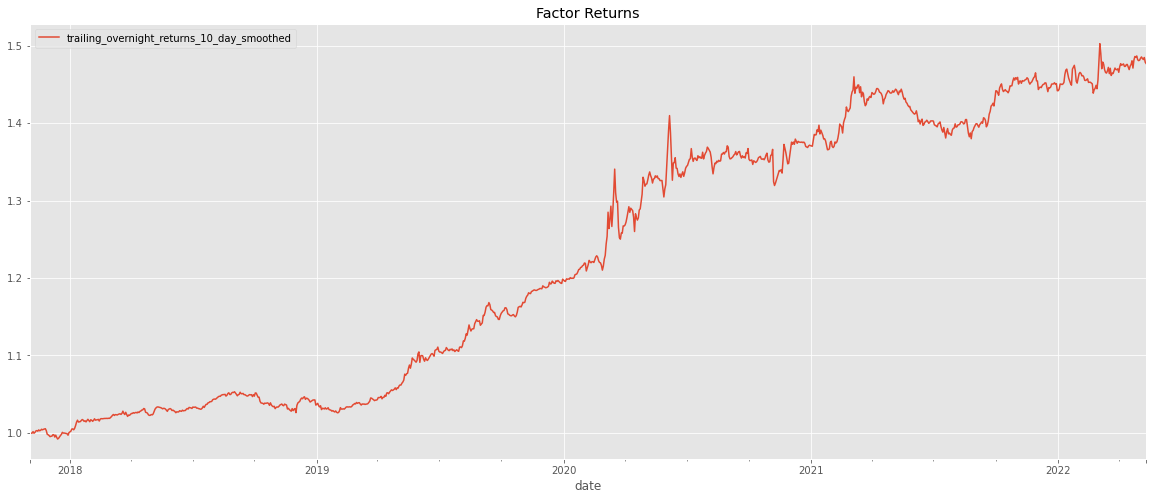

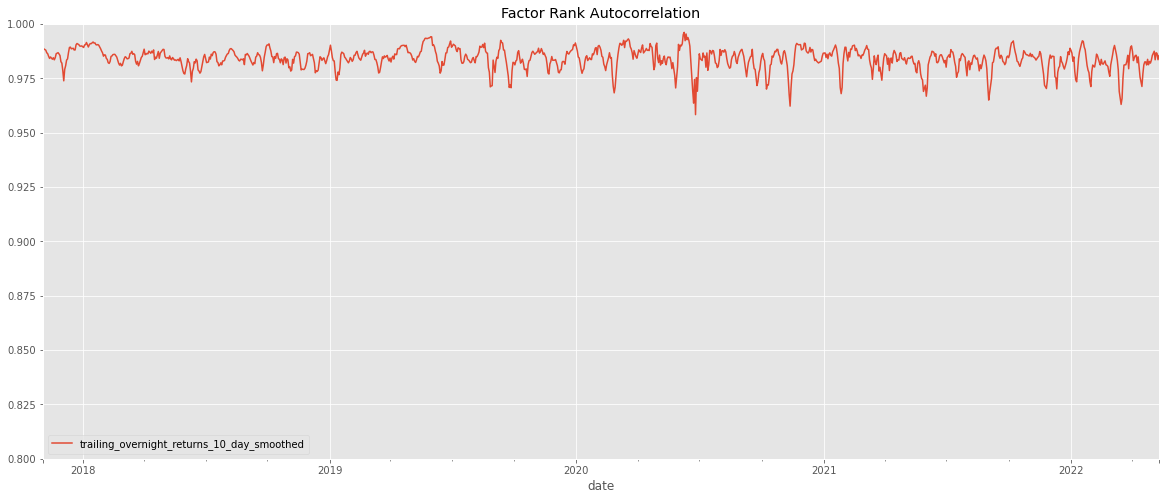

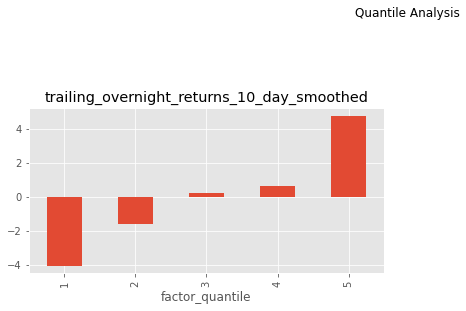

In [40]:
factor_returns, clean_factor_data, unixt_factor_data = alpha_factors.evaluate_alpha(all_factors[selected_factor_names], close)
factors_sharpe_ratio = alpha_factors.sharpe_ratio(factor_returns)

# Stage 2b: Generate Beta Factors

- Use Risk Model
- Compute Daily Betas for 1 year

In [5]:
logger.info(f'Generate beta factors...')
returns = alpha_factors.FactorReturns(price_histories).factor_data.dropna()
end_date = returns.index.max()
number_of_beta_years = int(default_config["NumberOfYearsPriceHistories"]) - 1
start_date = end_date - pd.offsets.DateOffset(years=number_of_beta_years)
logger.info(f'Generating {number_of_beta_years} year Betas from {start_date} to {end_date}')
beta_dates = pd.date_range(start_date, end_date, freq='D')
daily_betas = {}
for beta_date in tqdm(returns[start_date:].index, desc='Dates', unit=' Daily Beta'):
    start_of_returns = beta_date - pd.offsets.DateOffset(years=1)
    beta_returns = returns.loc[start_of_returns:beta_date]
    risk_model = alpha_factors.RiskModelPCA(beta_returns, 1, 20)
    daily_betas[beta_date.strftime('%m/%d/%Y')] = risk_model

logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')
with open(beta_factors_file_name, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(daily_betas, f, pickle.HIGHEST_PROTOCOL)

2022-05-16 09:01:33,990|GenerateAlphaAndBetaFactors|INFO|Generate beta factors...
2022-05-16 09:01:34,047|GenerateAlphaAndBetaFactors|INFO|Generating 4 year Betas from 2018-05-13 00:00:00 to 2022-05-13 00:00:00


Dates:   0%|          | 0/1009 [00:00<?, ? Daily Beta/s]

2022-05-16 09:02:11,926|GenerateAlphaAndBetaFactors|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
